In [ ]:
import nltk

nltk.download('vader_lexicon')

In [ ]:
import requests
import csv
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Function to label comments with sentiment using VADER
def label_comment_vader(comment):
    sid = SentimentIntensityAnalyzer()
    sentiment_scores = sid.polarity_scores(comment)

    # Determine sentiment based on compound score
    if sentiment_scores['compound'] >= 0.05:
        return 'positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

client_id = '9vg3v5h_IS-VW-A5JuSIgw'
client_secret = ''
username = ''
password = ''
user_agent = 'Group 33 ml project'

# Get an access token
auth_url = 'https://www.reddit.com/api/v1/access_token'
auth_data = {
    'grant_type': 'password',
    'username': username,
    'password': password
}
auth_headers = {'User-Agent': user_agent}
auth_response = requests.post(auth_url, data=auth_data, headers=auth_headers, auth=(client_id, client_secret))

if auth_response.status_code == 200:
    access_token = auth_response.json()['access_token']
    print(f'Access Token: {access_token}')

    subreddit = 'news'
    article_id = '7ej943'

    params = {'limit': 100}
    after = None

    while True:
        if after:
            params['after'] = after

        comments_url = f'https://oauth.reddit.com/r/{subreddit}/comments/{article_id}'
        headers = {'Authorization': f'bearer {access_token}', 'User-Agent': user_agent}
        comments_response = requests.get(comments_url, headers=headers, params=params)


        if comments_response.status_code == 200:

            comments_data = comments_response.json()[1]['data']['children']


            comments = [comment['data']['body'] if 'body' in comment['data'] else '' for comment in comments_data]


            labels = [label_comment_vader(comment) for comment in comments]

            # Save to CSV
            output_file = 'reddit_comments_sentiment.csv'
            with open(output_file, 'a', newline='', encoding='utf-8') as csvfile:
                fieldnames = ['Comment', 'Sentiment']
                writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

                for comment, label in zip(comments, labels):
                    writer.writerow({'Comment': comment, 'Sentiment': label})

            print(f'Data appended to {output_file}')

            after = comments_response.json()[1]['data']['after']

            if not after:
                break

        else:
            print(f'Error fetching comments. Status code: {comments_response.status_code}, Response: {comments_response.json()}')
            break
else:
    print(f'Authentication failed. Status code: {auth_response.status_code}, Response: {auth_response.json()}')


In [ ]:
pip install matplotlib

In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.preprocessing import LabelEncoder

# Read the CSV file
data = pd.read_csv('reddit_comments_sentiment.csv', delimiter='\t', header=None, names=['Text', 'Sentiment'])

# Fill NaN values in the 'Sentiment' column with a default value (e.g., 'neutral')
data['Sentiment'].fillna('neutral', inplace=True)

# Function for text processing
def preprocess_text(text):
    # Remove special characters and convert to lowercase
    text = ' '.join([word.lower() for word in word_tokenize(text) if word.isalnum()])
    return text

# Apply text cleaning to the 'Text' column
data['Text'] = data['Text'].apply(preprocess_text)

# Tokenization, stopwords removal, and lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

data['Text'] = data['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(x) if word not in stop_words]))

# Save the preprocessed data to a new file
data.to_csv('preprocessed_data.csv', index=False)

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save training and testing sets to separate files
train_data.to_csv('train_data.csv', index=False)
test_data.to_csv('test_data.csv', index=False)

# Feature extraction using TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_data['Text'])
y_train = train_data['Sentiment']

# Train Naive Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Transform the test set using the same vectorizer
X_test = tfidf_vectorizer.transform(test_data['Text'])

# Predict on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(test_data['Sentiment'], y_pred)
classification_rep = classification_report(test_data['Sentiment'], y_pred)

# Print evaluation metrics
print(f'Accuracy: {accuracy:.2f}')
print('Classification Report:')
print(classification_rep)

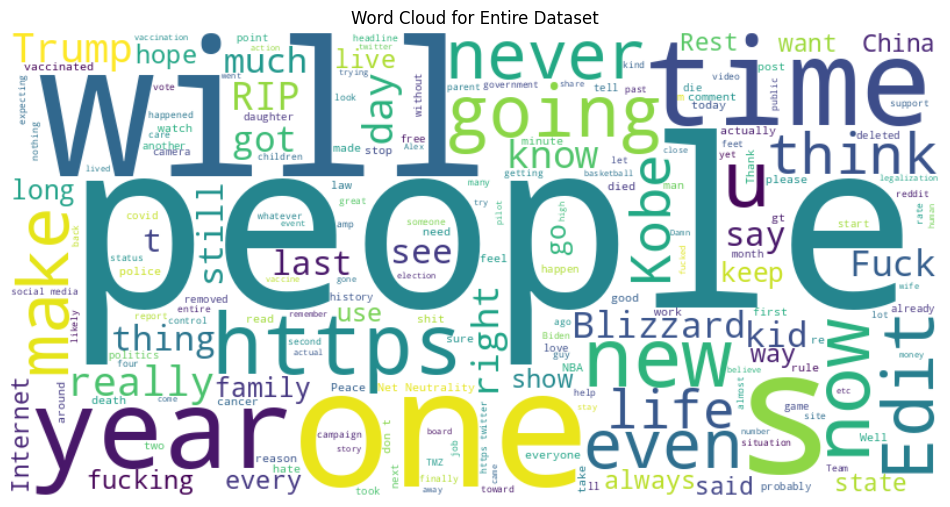

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_text = " ".join(data['Text'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Entire Dataset')
plt.axis('off')
plt.show()

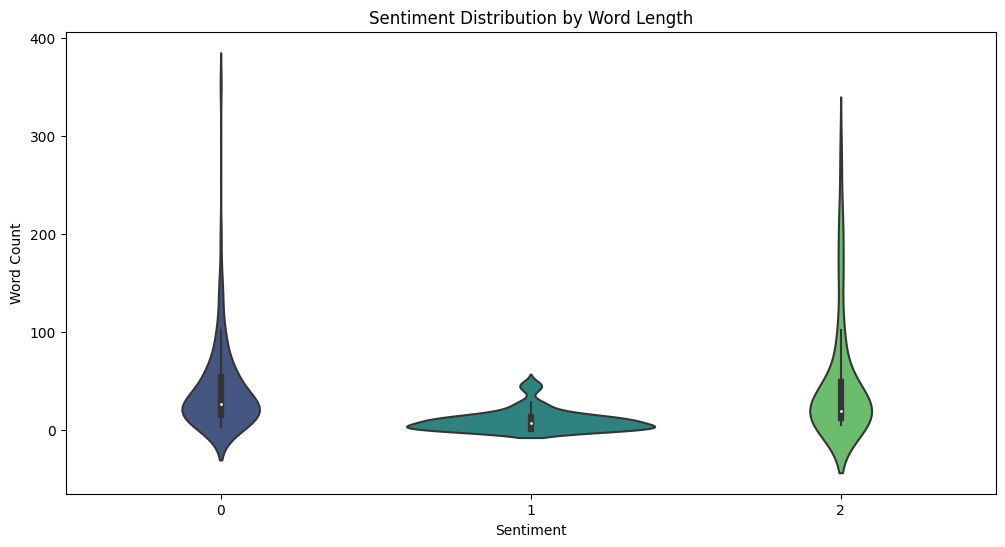

In [ ]:
data['Word_Count'] = data['Text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12, 6))
sns.violinplot(x='Sentiment', y='Word_Count', data=data, palette='viridis')
plt.title('Sentiment Distribution by Word Length')
plt.xlabel('Sentiment')
plt.ylabel('Word Count')
plt.show()

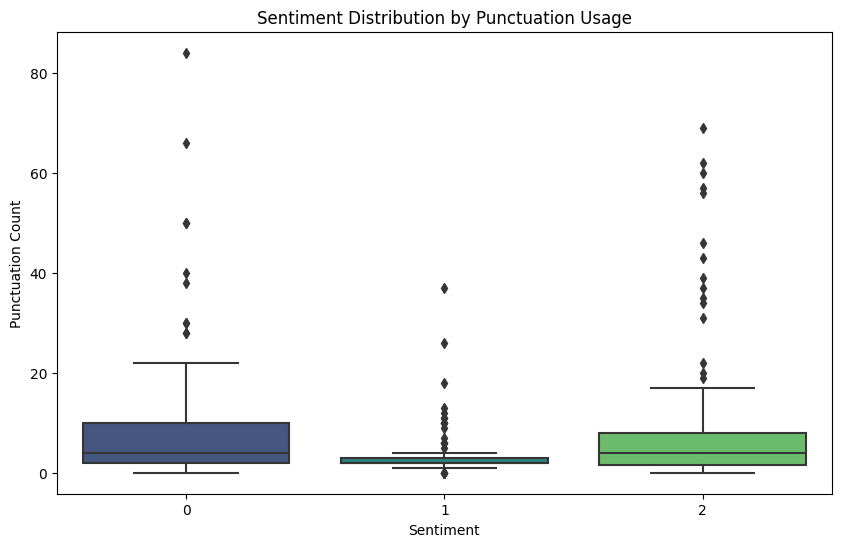

In [ ]:
import string

data['Punctuation_Count'] = data['Text'].apply(lambda x: sum(1 for char in x if char in string.punctuation))
plt.figure(figsize=(10, 6))
sns.boxplot(x='Sentiment', y='Punctuation_Count', data=data, palette='viridis')
plt.title('Sentiment Distribution by Punctuation Usage')
plt.xlabel('Sentiment')
plt.ylabel('Punctuation Count')
plt.show()

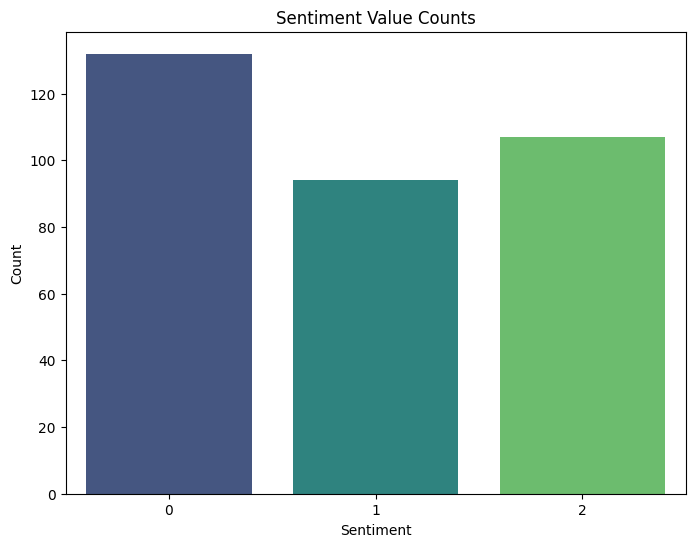

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Sentiment', data=data, palette='viridis')
plt.title('Sentiment Value Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

Data gathered from this Reddit Comments Dataset is all from r/news, with some of the top posts of all time as well as posts from "Top" of this week.
